## CITS2402 - Introduction to Data Science - Assignment.

### Comparing Demographic Trends in Australian and New Zealand Census Data

**Date:** August 2024.

## Declaration

This declaration should be completed and remain attached to the top of your submission.

*I/we am/are aware of the University’s [policy on academic conduct](https://www.uwa.edu.au/policy/-/media/Project/UWA/UWA/Policy-Library/Policy/Student-Administration/Academic-Integrity/Academic-Integrity-Policy.doc) and I declare that this assignment is entirely the work of the author(s) listed below and that suitable acknowledgement has been made for any sources of information used in preparing it. I have retained a copy for my own records.*

- Name 1:
- Student ID 1:
- Name 2: 
- Student ID 2:
- Name 3:
- Student ID 3:
- Date:


The suffix `-template` should be replaced with the corresponding student numbers. For instance, if you are doing your assignment with another person, you should rename your file as `CITS2402-Assignment-STDNO1-STDNO2.ipynb`, where 'STDNO1' and 'STDNO2' are the corresponding student numbers involved in the submission. 

<hr>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
ds_path = "./datasets"

aus2016_a = pd.read_csv(f'{ds_path}/AUS/2016/2016Census_G51A_AUS.csv')
aus2016_b = pd.read_csv(f'{ds_path}/AUS/2016/2016Census_G51B_AUS.csv')
aus2016_c = pd.read_csv(f'{ds_path}/AUS/2016/2016Census_G51C_AUS.csv')
aus2016_d = pd.read_csv(f'{ds_path}/AUS/2016/2016Census_G51D_AUS.csv')

aus2016 = aus2016_a.merge(aus2016_b).merge(aus2016_c).merge(aus2016_d)

male_total = aus2016["M_Tot_Tot"][0]
male_health = aus2016["M_HlthCare_SocAs_Tot"][0]
male_not_health = male_total - male_health

female_total = aus2016["F_Tot_Tot"][0]
female_health = aus2016["F_HlthCare_SocAs_Tot"][0]
female_not_health = female_total - female_health

person_total = aus2016["P_Tot_Tot"][0]
person_health = aus2016["P_HlthCare_SocAs_Tot"][0]
person_not_health = person_total - person_health

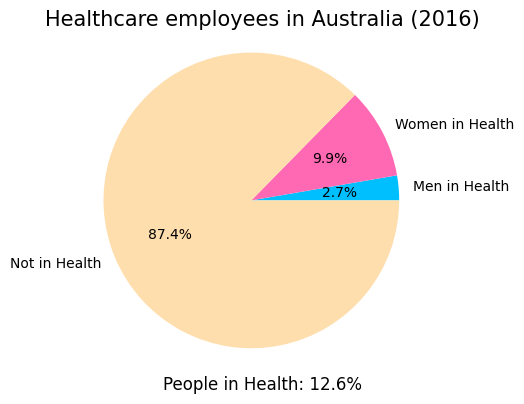

In [106]:
plt.pie([male_health, female_health, person_not_health], labels=["Men in Health", "Women in Health", "Not in Health"], colors=["deepskyblue", "hotpink", "navajowhite"], autopct='%1.1f%%')
plt.title("Healthcare employees in Australia (2016)", x = 0.53, y = 0.95, fontsize = 15)
plt.figtext(0.53, 0.1, f"People in Health: {(person_health / person_total * 100):.1f}%", ha='center', fontsize=12)
plt.show()